In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import os
import scipy.stats
from scipy.interpolate import interp1d

In [2]:
filepath = '/ihme/csu/swiss_re/forecast/'

# just look at single demographic group for now
location = 'Zhejiang'
age_group = ['60 to 64']
age_group_id = [17]
sex = 'Female'
year = 2019

In [3]:
# import exposure forecst data
prevalence = pd.read_csv(filepath + 'prev_forecast_bounds.csv')
packyears = pd.read_csv(filepath + 'py_forecast_bounds.csv')
ysq = pd.read_csv(filepath + 'ysq_forecast_bounds.csv')

In [4]:
prev_data = (prevalence.loc[prevalence.sex_id == sex].loc[prevalence.year_id == year]
             .loc[prevalence.location_id == location].loc[prevalence.age_group_id.isin(age_group)])
current_prev = prev_data.lower.values[0]
former_prev = prev_data.lower.values[1]

In [5]:
py_data = (packyears.loc[packyears.sex_id == sex].loc[packyears.year_id == year]
             .loc[packyears.location_id == location].loc[packyears.age_group_id.isin(age_group)])
ysq_data = (packyears.loc[packyears.sex_id == sex].loc[packyears.year_id == year]
             .loc[packyears.location_id == location].loc[packyears.age_group_id.isin(age_group)])

In [6]:
# load relative risk data
rr_current = pd.read_csv('/home/j/WORK/05_risk/risks/TEAM/sub_risks/tobacco/raw_data/metadata/rr/systematic_review_extraction_sheets/draws_for_PAF/426_lung_cancer/draws_pack.csv')
rr_current_data = rr_current.loc[rr_current.sex_id==1].loc[rr_current.age_group_id.isin(age_group_id)]
rr_current_data = rr_current_data.groupby(['exposure','sex_id','age_group_id'], as_index=False).mean().drop(columns='draw')
x = rr_current_data.exposure.values
y = rr_current_data.rr.values
current_rr_function = interp1d(x, y)
max_py = x.max()

rr_former = pd.read_csv('/home/j/WORK/05_risk/risks/TEAM/sub_risks/tobacco/raw_data/metadata/rr/systematic_review_extraction_sheets/draws_for_PAF/426_lung_cancer/draws_quit.csv')
rr_former_data = rr_former.loc[rr_former.sex_id==1].loc[rr_former.age_group_id.isin(age_group_id)] 
rr_former_data = rr_former_data.groupby(['exposure','sex_id','age_group_id'], as_index=False).mean().drop(columns='draw')
x = rr_former_data.exposure.values
y = rr_former_data.rr.values
former_rr_function = interp1d(x, y)
max_ysq = x.max()

In [7]:
# assign exposures to simulants
n_simulants = 100_000
sims = pd.DataFrame()
sims['smoking_status'] = np.random.choice(['current','former','never'],
                                          n_simulants, p=[current_prev,former_prev,1 - current_prev - former_prev])
sims['py_cat'] = np.where(sims.smoking_status == 'current',
                             np.random.choice(py_data.bin.values, 
                                              n_simulants, p=(py_data['median'].values / py_data['median'].sum())), '0 to 0')
sims['ysq_cat'] = np.where(sims.smoking_status == 'former',
                             np.random.choice(ysq_data.bin.values, 
                                              n_simulants, p=(ysq_data['median'].values / ysq_data['median'].sum())), '0 to 0')

sims['py_min'] = sims['py_cat'].str.split(' ', n=2, expand=True)[0].astype(int)
sims['py_max'] = sims['py_cat'].str.split(' ', n=2, expand=True)[2].astype(int) + 1
sims['ysq_min'] = sims['ysq_cat'].str.split(' ', n=2, expand=True)[0].astype(int)
sims['ysq_max'] = sims['ysq_cat'].str.split(' ', n=2, expand=True)[2].astype(int) + 1

sims['py_max'] = sims.py_max.replace(100, max_py).replace(1, 0)
sims['ysq_max'] = sims.ysq_max.replace(100, max_ysq).replace(1, 0)

sims['py_val_uniform'] = np.random.uniform(sims.py_min, sims.py_max)
sims['ysq_val_uniform'] = np.random.uniform(sims.ysq_min, sims.ysq_max)

sims['py_val_trap'] = scipy.stats.trapz.rvs(0,1,loc=sims.py_min,scale=sims.py_max - sims.py_min)
sims['ysq_val_trap'] = scipy.stats.trapz.rvs(0,1,loc=sims.ysq_min,scale=sims.ysq_max - sims.ysq_min)

sims.head()

,smoking_status,py_cat,ysq_cat,py_min,py_max,ysq_min,ysq_max,py_val_uniform,ysq_val_uniform,py_val_trap,ysq_val_trap
0,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [8]:
# assign relative risks based on risk curve function
sims['rr_uniform'] = np.where(sims.smoking_status == 'former', former_rr_function(sims.ysq_val_uniform),
                              current_rr_function(sims.py_val_uniform))
sims['rr_trap'] = np.where(sims.smoking_status == 'former', former_rr_function(sims.ysq_val_trap),
                              current_rr_function(sims.py_val_trap))
sims['rr_min'] = np.where(sims.smoking_status == 'former', former_rr_function(sims.ysq_min),
                              current_rr_function(sims.py_min))
sims.head()

,smoking_status,py_cat,ysq_cat,py_min,py_max,ysq_min,ysq_max,py_val_uniform,ysq_val_uniform,py_val_trap,ysq_val_trap,rr_uniform,rr_trap,rr_min
0,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,never,0 to 0,0 to 0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [9]:
sims.rr_uniform.mean()

1.2158178058672047

In [10]:
sims.rr_trap.mean()

1.2167116180846915

In [11]:
sims.rr_min.mean()

1.1808175927623437

In [12]:
(sims.rr_uniform.mean() - 1)/sims.rr_uniform.mean()

0.1775083444457935

In [13]:
(sims.rr_trap.mean() - 1)/sims.rr_trap.mean()

0.17811255753917432

In [14]:
(sims.rr_min.mean() - 1)/sims.rr_min.mean()

0.15312914871072367

In [15]:
# now pull paf for comparison
paf = pd.read_csv('/ihme/gbd/WORK/05_risk/TEAM/sub_risks/tobacco/smoking_direct_prev/exposure/modeling/GBD2019/outputs/paf/final/pafs_ss_annual/491_2.csv')
paf = paf.loc[paf.year_id==2019].loc[paf.cause_id==426].loc[paf.age_group_id.isin(age_group_id)]
paf = paf.set_index([c for c in paf.columns if 'draw' not in c])
paf = pd.DataFrame(paf.mean(axis=1))
paf.head()

0
rei_id location_id year_id age_group_id sex_id cause_id measure_id          
99     491         2019    17           2      426      3           0.158002
                                                        4           0.158002

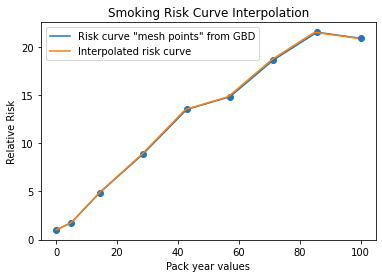

In [16]:
from scipy.interpolate import interp1d
x = rr_current_data.exposure.values
y = rr_current_data.rr.values
f = interp1d(x, y)

x_new = np.linspace(x.min(), x.max(), num=100, endpoint=True)
f(x_new)

plt.scatter(x, y)
plt.plot(x, y, f(x_new))
plt.title('Smoking Risk Curve Interpolation')
plt.xlabel('Pack year values')
plt.ylabel('Relative Risk')
plt.legend(['Risk curve "mesh points" from GBD',
           'Interpolated risk curve'])